# 🐶 Classifying Different Dog Breeds

In this project we're going to be using machine learning to help us identify different breeds of dogs.

To do this, we'll be using data from the [Kaggle dog breed identification competition](https://www.kaggle.com/c/dog-breed-identification/overview). It consists of a collection of 10,000+ labelled images of 120 different dog breeds.

This kind of problem is called multi-class image classification. It's multi-class because we're trying to classify mutliple different breeds of dog. If we were only trying to classify dogs versus cats, it would be called binary classification (one thing versus another).

Multi-class image classification is an important problem because it's the same kind of technology Tesla uses in their self-driving cars or Airbnb uses in atuomatically adding information to their listings.

Since the most important step in a deep learng problem is getting the data ready (turning it into numbers), that's what we're going to start with.

We're going to go through the following TensorFlow/Deep Learning workflow:
1. Get data ready (download from Kaggle, store, import).
2. Prepare the data (preprocessing, the 3 sets, X & y).
3. Choose and fit/train a model ([TensorFlow Hub](https://www.tensorflow.org/hub), `tf.keras.applications`, [TensorBoard](https://www.tensorflow.org/tensorboard), [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)).
4. Evaluating a model (making predictions, comparing them with the ground truth labels).
5. Improve the model through experimentation (start with 1000 images, make sure it works, increase the number of images).
6. Save, sharing and reloading your model (once you're happy with the results).

For preprocessing our data, we're going to use TensorFlow 2.x. The whole premise here is to get our data into Tensors (arrays of numbers which can be run on GPUs) and then allow a machine learning model to find patterns between them.

For our machine learning model, we're going to be using a pretrained deep learning model from TensorFlow Hub.

The process of using a pretrained model and adapting it to your own problem is called **transfer learning**. We do this because rather than train our own model from scratch (could be timely and expensive), we leverage the patterns of another model which has been trained to classify images.



In [3]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Check for GPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.15.0
Hub version: 0.16.1
GPU available (YESS!!!!)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Use the '-d' parameter as the destination for where the files should go
# !unzip "drive/My Drive/Data/dog-breed-identification.zip" -d "drive/My Drive/Data/"

Once the files have been unzipped to your Google Drive, you don't have to run the cell above anymore.

### Accessing the data

Now the data files we're working with are available on our Google Drive, we can start to check it out.

Let's start with `labels.csv` which contains all of the image ID's and their assosciated dog breed (our data and labels).

In [7]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Data/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


Looking at this, we can see there are 10222 different ID's (meaning 10222 different images) and 120 different breeds.

Let's figure out how many images there are of each breed.

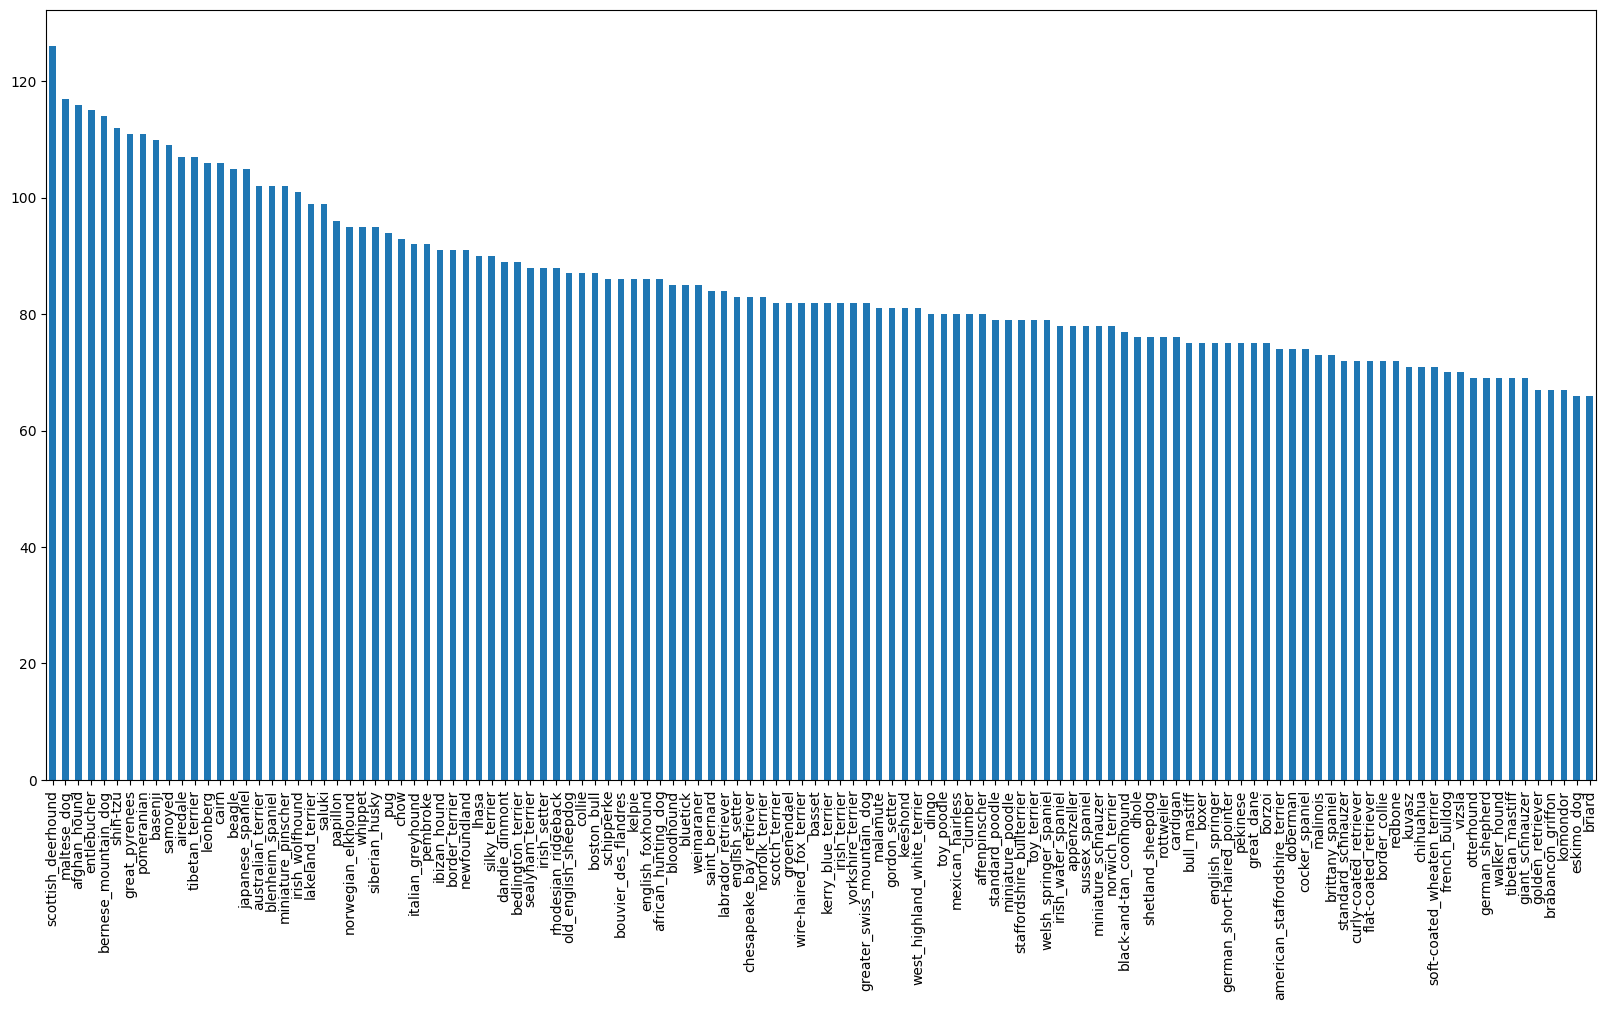

In [8]:

labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

If we were to roughly draw a line across the middle of the graph, we'd see there's about 60+ images for each dog breed.

This is a good amount as for some of their vision products [Google recommends a minimum of 10 images per class to get started](https://cloud.google.com/vision/automl/object-detection/docs/prepare). And as you might imagine, the more images per class available, the more chance a model has to figure out patterns between them.

Let's check out one of the images.

**Note:** Loading an image file for the first time may take a while as it gets loaded into the runtime memory. If you see a Google Drive timeout error, check out the [Colab FAQ](https://research.google.com/colaboratory/faq.html#drive-timeout) for more.

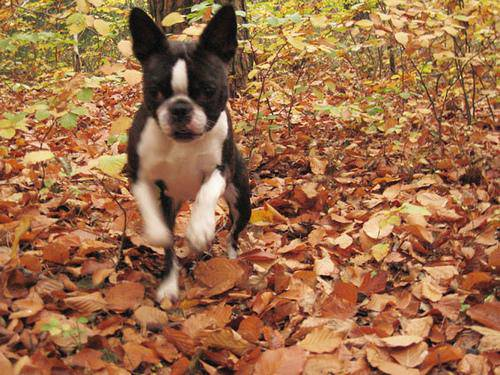

In [9]:
from IPython.display import display, Image
Image("drive/My Drive/Data/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting images and their labels

Since we've got the image ID's and their labels in a DataFrame (`labels_csv`), we'll use it to create:
* A list a filepaths to training images
* An array of all labels
* An array of all unique labels

We'll only create a list of filepaths to images rather than importing them all to begin with. This is because working with filepaths (strings) is much efficient than working with images.

In [10]:
# Create pathnames from image ID's
filenames = ["drive/My Drive/Data/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10 filenames
filenames[:10]

['drive/My Drive/Data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

Now we've got a list of all the filenames from the ID column of `labels_csv`, we can compare it to the number of files in our training data directory to see if they line up.

If they do, great. If not, there may have been an issue when unzipping the data (what we did above), to fix this, you might have to unzip the data again. Be careful not to let your Colab notebook disconnect whilst unzipping.

In [11]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/My Drive/Data/train/")) == len(filenames):
  print("Filenames match actual amount of files!")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!


If everything worked, we should see a match up.

Let's do one more check. Visualizing directly from a filepath.

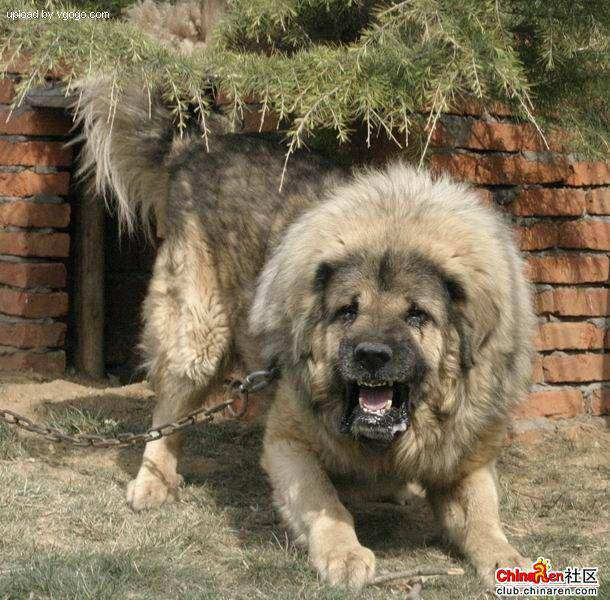

In [12]:
# Check an image directly from a filepath
Image(filenames[9000])


We'll take them from `labels_csv` and turn them into a NumPy array.

In [13]:
import numpy as np
labels = labels_csv["breed"].to_numpy() # convert labels column to NumPy array
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

Now lets do the same thing as before, compare the amount of labels to number of filenames.

In [14]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


If it all worked, we should have the same amount of images and labels.

Finally, since a machine learning model can't take strings as input (what `labels` currently is), we'll have to convert our labels to numbers.

To begin with, we'll find all of the unique dog breed names.

Then we'll go through the list of `labels` and compare them to unique breeds and create a list of booleans indicating which one is the real label (`True`) and which ones aren't (`False`).

In [15]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

The length of `unique_breeds` should be 120, meaning we're working with images of 120 different breeds of dogs.

Now use `unique_breeds` to help turn our `labels` array into an array of booleans.

In [16]:
# Example: Turn one label into an array of booleans
print(labels[0])
labels[0] == unique_breeds # use comparison operator to create boolean array

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [17]:
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In this case, we've transformed a single dog breed name such as `boston_bull` into a one-hot array.

Let's see an example.

In [18]:
# Example: Turning a boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])[0][0]) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
19
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set (a split of the data we can test our model on before making final predicitons on the test set), let's make one.

We could use Scikit-Learn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function or we could simply make manual splits of the data.

For accessibility later, let's save our filenames variable to `X` (data) and our labels to `y`.

In [19]:
# Setup X & y variables
X = filenames
y = boolean_labels

Since we're working with 10,000+ images, it's a good idea to work with a portion of them to make sure things are working before training on them all.

This is because computing with 10,000+ images could take a fairly long time. And our goal when working through machine learning projects is to reduce the time between experiments.

Let's start experimenting with 1000 and increase it as we need.

In [20]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}
NUM_IMAGES

1000

Now let's split our data into training and validation sets. We'll use and 80/20 split (80% training data, 20% validation data).

In [21]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [22]:
# Check out the training data (image file paths and labels)
X_train[:5], y_train[:2]

(['drive/My Drive/Data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Data/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Data/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         Fa

### Preprocessing images (turning images into Tensors)

Our labels are in numeric format but our images are still just file paths.

Since we're using TensorFlow, our data has to be in the form of Tensors.

A Tensor is a way to represent information in numbers. If you're familar with NumPy arrays (you should be), a Tensor can be thought of as a combination of NumPy arrays, except with the special ability to be used on a GPU.

Because of how TensorFlow stores information (in Tensors), it allows machine learning and deep learning models to be run on GPUs (generally faster at numerical computing).

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Takes an image filename as input.
2. Uses TensorFlow to read the file and save it to a variable, `image`.
3. Turn our `image` (a jpeg file) into Tensors.
4. Resize the `image` to be of shape (224, 224).
5. Return the modified `image`.

In [23]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42]) # read in an image
image.shape

(257, 350, 3)

Notice the shape of `image`. It's (257, 350, 3). This is height, width, colour channel value.

And you can easily convert it to a Tensor using [`tf.constant()`](https://www.tensorflow.org/api_docs/python/tf/constant).

In [24]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

In [25]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

### Creating data batches

WNow we've got a function to convert our images into Tensors, we'll now build one to turn our data into batches (more specifically, a TensorFlow [`BatchDataset`](https://www.tensorflow.org/guide/data#batching_dataset_elements)).

What's a batch?

A batch (also called mini-batch) is a small portion of your data, say 32 (32 is generally the default batch size) images and their labels. In deep learning, instead of finding patterns in an entire dataset at the same time, you often find them one batch at a time.

Let's say you're dealing with 10,000+ images (which we are). Together, these files may take up more memory than your GPU has. Trying to compute on them all would result in an error.

Instead, it's more efficient to create smaller batches of your data and compute on one batch at a time.

TensorFlow is very efficient when your data is in batches of (image, label) Tensors. So we'll build a function to do create those first. We'll take advantage of of `process_image` function at the same time.

In [26]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

Now we've got a simple function to turn our image file path names and their associated labels into tuples (we can turn these into Tensors next), we'll create a function to make data batches.

Because we'll be dealing with 3 different sets of data (training, validation and test), we'll make sure the function can accomodate for each set.

We'll set a default batch size of 32 because [according to Yann Lecun](https://twitter.com/ylecun/status/989610208497360896?s=20) (one of the OG's of deep learning), friends don't let friends train with batch sizes over 32.

In [27]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [28]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [29]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

Look at that! We've got our data in batches, more specifically, they're in Tensor pairs of (images, labels) ready for use on a GPU.

But having our data in batches can be a bit of a hard concept to understand. Let's build a function which helps us visualize what's going on under the hood.

### Visualizing data batches

In [30]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

To make computation efficient, a batch is a tighly wound collection of Tensors.

So to view data in a batch, we've got to unwind it.

We can do so by calling the [`as_numpy_iterator()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator) method on a data batch.

This will turn our a data batch into something which can be iterated over.

Passing an iterable to [`next()`](https://docs.python.org/3/library/functions.html#next) will return the next item in the iterator.

In our case, next will return a batch of 32 images and label pairs.

**Note:** Running the cell below and loading images may take a little while.

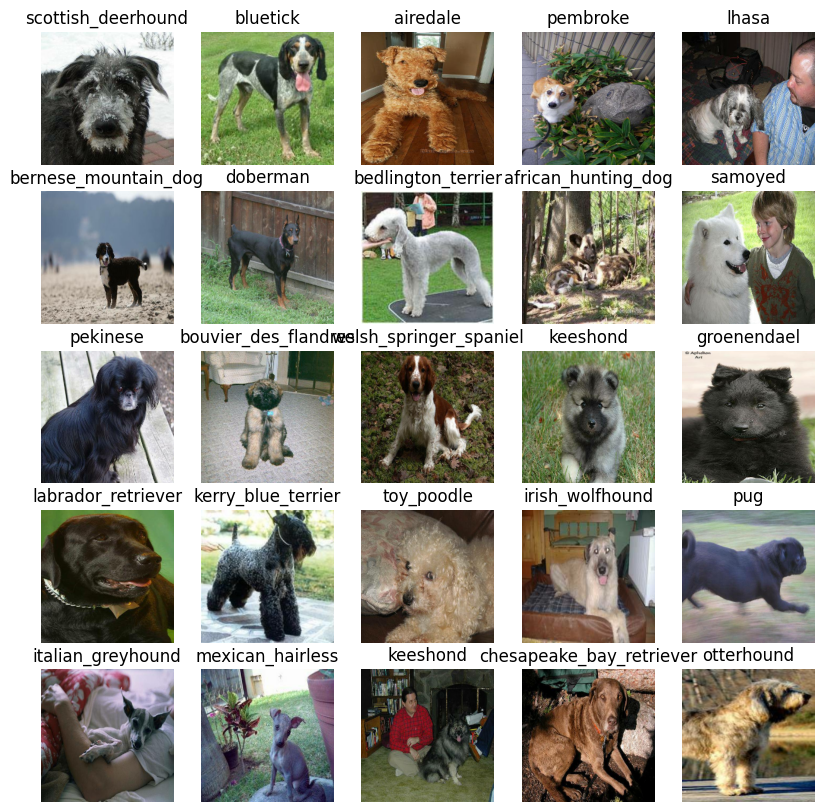

In [31]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

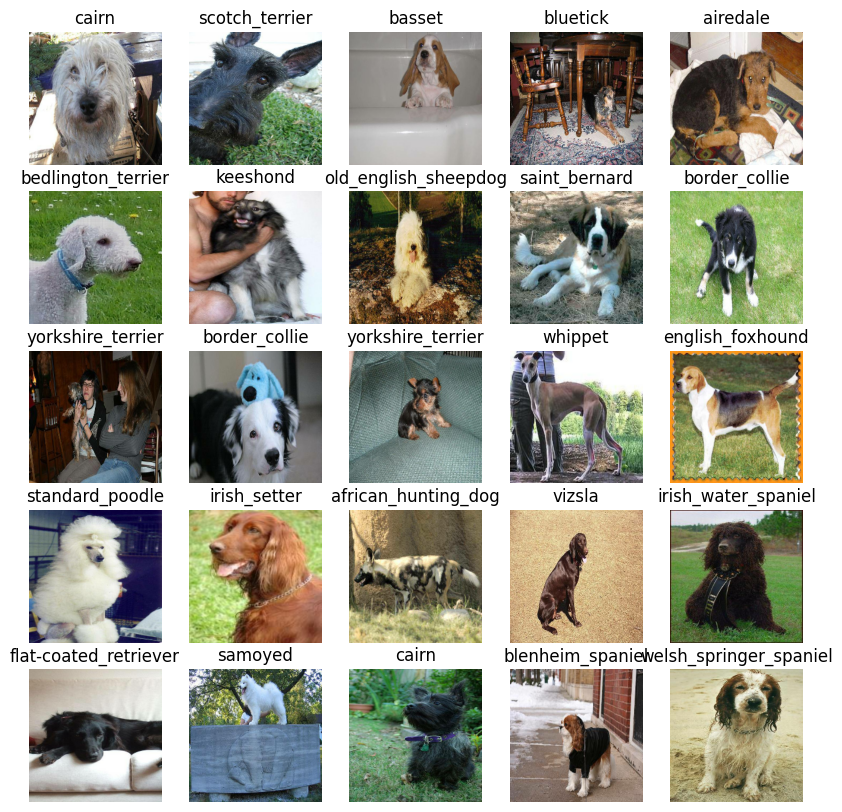

In [32]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

Even more dogs!

**Question:** Why does running the cell above and viewing validation images return the same dogs each time?

# Creating and training a model

Now our data is ready, let's prepare it modelling. We'll use an existing model from [TensorFlow Hub](https://tfhub.dev/).

#### Why use a pretrained model?

Building a machine learning model and training it on lots from scratch can be expensive and time consuming.

Transfer learning helps eliviate some of these by taking what another model has learned and using that information with your own problem.

#### How do we choose a model?

Since we know our problem is image classification (classifying different dog breeds), we can navigate the [TensorFlow Hub page by our problem domain (image)](https://tfhub.dev/s?module-type=image-augmentation,image-classification,image-feature-vector,image-generator,image-object-detection,image-others,image-style-transfer,image-rnn-agent).

We start by choosing the image problem domain, and then can filter it down by subdomains, in our case, [image classification](https://tfhub.dev/s?module-type=image-classification).

Doing this gives a list of different pretrained models we can apply to our task.

Clicking on one gives us information about the model as well as instructions for using it.

For example, clicking on the [mobilenet_v2_130_224](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4) model, tells us this model takes an input of images in the shape 224, 224. It also says the model has been trained in the domain of image classification.

Let's try it out.

### Building a model

Before we build a model, there are a few things we need to define:
* The input shape (images, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use.

These things will be standard practice with whatever machine learning model you use. And because we're using TensorFlow, everything will be in the form of Tensors.


In [33]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got the inputs, outputs and model we're using ready to go. We can start to put them together

There are many ways of building a model in TensorFlow but one of the best ways to get started is to [use the Keras API](https://www.tensorflow.org/guide/keras/overview).

Defining a deep learning model in Keras can be as straightforward as saying, "here are the layers of the model, the input shape and the output shape, let's go!"

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen's URL as parameters.
* Defines the layers in a Keras model in a sequential fashion (do this first, then this, then that).
* Compiles the model (says how it should be evaluated and improved).
* Builds the model (tells it what kind of input shape it'll be getting).
* Returns the model.

We'll take a look at the code first, then dicuss each part.

In [34]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting

  return model

#### Setting up the model layers

There are two ways to do this in Keras, the [functional](https://www.tensorflow.org/guide/keras/functional) and [sequential API](https://www.tensorflow.org/guide/keras/overview#build_a_simple_model). We've used the sequential.

Which one should you use?

The Keras documentation states the functional API is the way to go for defining complex models but the sequential API (a linear stack of layers) is perfectly fine for getting started, which is what we're doing.

The first layer we use is the model from TensorFlow Hub (`hub.KerasLayer(MODEL_URL)`. So our first layer is actually an entire model (many more layers). This **input layer** takes in our images and finds patterns in them based on the patterns [`mobilenet_v2_130_224`](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4) has found.

The next layer (`tf.keras.layers.Dense()`) is the **output layer** of our model. It brings all of the information discovered in the input layer together and outputs it in the shape we're after, 120 (the number of unique labels we have).

The `activation="softmax"` parameter tells the output layer, we'd like to assign a probability value to each of the 120 labels [somewhere between 0 & 1](https://en.wikipedia.org/wiki/Softmax_function). The higher the value, the more the model believes the input image should have that label. If we were working on a binary classification problem, we'd use `activation="sigmoid"`.

For more on which activation function to use, see the article [Which Loss and Activation Functions Should I Use](https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8)?

#### Compiling the model

This one is best explained with a story.

Let's say you're at the international hill descending championships. Where your start standing on top of a hill and your goal is to get to the bottom of the hill. The catch is you're blindfolded.

Luckily, your friend Adam is standing at the bottom of the hill shouting instructions on how to get down.

At the bottom of the hill there's a judge evaluating how you're doing. They know where you need to end up so they compare how you're doing to where you're supposed to be. Their comparison is how you get scored.

Transferring this to `model.compile()` terminology:
* `loss` - The height of the hill is the loss function, the models goal is to minimize this, getting to 0 (the bottom of the hill) means the model is learning perfectly.
* `optimizer` - Your friend Adam is the optimizer, he's the one telling you how to navigate the hill (lower the loss function) based on what you've done so far. His name is Adam because the [Adam optimizer](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) is a great general which performs well on most models. Other optimizers include [RMSprop](https://ruder.io/optimizing-gradient-descent/index.html#rmsprop) and [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).
* `metrics` - This is the onlooker at the bottom of the hill rating how well your perfomance is. Or in our case, giving the accuracy of how well our model is predicting the correct image label.

#### Building the model

We use `model.build()` whenever we're using a layer from TensorFlow Hub to tell our model what input shape it can expect.

In this case, the input shape is `[None, IMG_SIZE, IMG_SIZE, 3]` or `[None, 224, 224, 3]` or `[batch_size, img_height, img_width, color_channels]`.

Batch size is left as `None` as this is inferred from the data we pass the model. In our case, it'll be 32 since that's what we've set up our data batches as.

Now we've gone through each section of the function, let's use it to create a model.

We can call `summary()` on our model to get idea of what our model looks like.

In [35]:
# Create a model and check its details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


The non-trainable parameters are the patterns learned by `mobilenet_v2_130_224` and the trainable parameters are the ones in the dense layer we added.

This means the main bulk of the information in our model has already been learned and we're going to take that and adapt it to our own problem.

### Creating callbacks

We've got a model ready to go but before we train it we'll make some callbacks.

Callbacks are helper functions a model can use during training to do things such as save a models progress, check a models progress or stop training early if a model stops improving.

The two callbacks we're going to add are a TensorBoard callback and an Early Stopping callback.

#### TensorBoard Callback

[TensorBoard](https://www.tensorflow.org/tensorboard/get_started) helps provide a visual way to monitor the progress of your model during and after training.

It can be used [directly in a notebook](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) to track the performance measures of a model such as loss and accuracy.

To set up a TensorBoard callback and view TensorBoard in a notebook, we need to do three things:
1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize the our models training logs using the `%tensorboard` magic function (we'll do this later on).

In [36]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [37]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/Data/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

#### Early Stopping Callback

[Early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) helps prevent overfitting by stopping a model when a certain evaluation metric stops improving. If a model trains for too long, it can do so well at finding patterns in a certain dataset that it's not able to use those patterns on another dataset it hasn't seen before (doesn't generalize).

It's basically like saying to our model, "keep finding patterns until the quality of those patterns starts to go down."



In [38]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

### Training a model (on a subset of data)
Our first model is only going to be trained on 1000 images. Or trained on 800 images and then validated on 200 images, meaning 1000 images total or about 10% of the total data.

We do this to make sure everything is working. And if it is, we can step it up later and train on the entire training dataset.

The final parameter we'll define before training is `NUM_EPOCHS` (also known as **number of epochs**).

`NUM_EPOCHS` defines how many passes of the data we'd like our model to do. A pass is equivalent to our model trying to find patterns in each dog image and see which patterns relate to each label.

If `NUM_EPOCHS=1`, the model will only look at the data once and will probably score badly because it hasn't a chance to correct itself. It would be like you competing in the international hill descent championships and your friend Adam only being able to give you 1 single instruction to get down the hill.

What's a good value for `NUM_EPOCHS`?

This one is hard to say. 10 could be a good start but so could 100. This is one of the reasons we created an early stopping callback. Having early stopping setup means if we set `NUM_EPOCHS` to 100 but our model stops improving after 22 epochs, it'll stop training.

Along with this, let's quickly check if we're still using a GPU.

In [39]:
# Check again if GPU is available (otherwise computing will take a looooonnnnggggg time)
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YESS!!!!)


In [40]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

We've got a GPU running and `NUM_EPOCHS` setup. Let's create a simple function which trains a model. The function will:
* Create a model using `create_model()`.
* Setup a TensorBoard callback using `create_tensorboard_callback()` (we do this here so it creates a log directory of the current date and time).
* Call the `fit()` function on our model passing it the training data, validatation data, number of epochs to train for and the callbacks we'd like to use.
* Return the fitted model.

In [41]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])

  return model

**Note:** When training a model for the first time, the first epoch will take a while to load compared to the rest. This is because the model is getting ready and the data is being initialised. Using more data will generally take longer, which is why we've started with ~1000 images. After the first epoch, subsequent epochs should take a few seconds.

In [ ]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
 5/25 [=====>........................] - ETA: 1:31 - loss: 5.4355 - accuracy: 0.0250

**Question:** It looks like our model might be overfitting (getting far better results on the training set than the validation set), what are some ways to prevent model overfitting? Hint: this may involve searching something like "ways to prevent overfitting in a deep learning model?".

**Note:** Overfitting to begin with is a good thing. It means our model is learning something.

#### Checking the TensorBoard logs
Now our model has been trained, we can make its performance visual by checking the TensorBoard logs.

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and viualize its contents.

In [ ]:
%tensorboard --logdir drive/MyDrive/Data/logs

Thanks to our `early_stopping` callback, the model stopped training after 26 or so epochs (in my case, yours might be slightly different). This is because the validation accuracy failed to improve for 3 epochs.

But the good new is, we can definitely see our model is learning something. The validation accuracy got to 65% in only a few minutes.

This means, if we were to scale up the number of images, hopefully we'd see the accuracy increase.

## Making and evaluating predictions using a trained model

Before we scale up and train on more data, let's see some other ways we can evaluate our model. Because although accuracy is a pretty good indicator of how our model is doing, it would be even better if we could could see it in action.

Making predictions with a trained model is as calling `predict()` on it and passing it data in the same format the model was trained on.

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go
predictions

In [ ]:
# Check the shape of predictions
predictions.shape

Making predictions with our model returns an array with a different value for each label.

In this case, making predictions on the validation data (200 images) returns an array (`predictions`) of arrays, each containing 120 different values (one for each unique dog breed).

These different values are the probabilities or the likelihood the model has predicted a certain image being a certain breed of dog. The higher the value, the more likely the model thinks a given image is a specific breed of dog.

Let's see how we'd convert an array of probabilities into an actual label.

In [ ]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # the predicted label

Having this information is great but it would be even better if we could compare a prediction to its true label and original image.

To help us, let's first build a little function to convert prediction probabilities into predicted labels.

**Note:** Prediction probabilities are also known as confidence levels.

In [ ]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

Now we've got a list of all different predictions our model has made, we'll do the same for the validation images and validation labels.

Remember, the model hasn't trained on the validation data, during the `fit()` function, it only used the validation data to evaluate itself. So we can use the validation images to visually compare our models predictions with the validation labels.

Since our validation data (`val_data`) is in batch form, to get a list of validation images and labels, we'll have to unbatch it (using [`unbatch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch)) and then turn it into an iterator using [`as_numpy_iterator()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator).

Let's make a small function to do so.

In [ ]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some functions to make these all a bit more visualize.

More specifically, we want to be able to view an image, its predicted label and its actual label (true label).

The first function we'll create will:
* Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

In [ ]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images)

Making functions to help visual your models results are really helpful in understanding how your model is doing.

Since we're working with a multi-class problem (120 different dog breeds), it would also be good to see what other guesses our model is making. More specifically, if our model predicts a certain label with 24% probability, what else did it predict?

Let's build a function to demonstrate. The function will:
* Take an input of a prediction probabilities array, a ground truth labels array and an integer.
* Find the predicted label using `get_pred_label()`.
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green.

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

In [ ]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading a model

After training a model, it's a good idea to save it. Saving it means you can share it with colleagues, put it in an application and more importantly, won't have to go through the potentially expensive step of retraining it.

The format of an [entire saved Keras model is h5](https://www.tensorflow.org/tutorials/keras/save_and_load). So we'll make a function which can take a model as input and utilise the [`save()`](https://www.tensorflow.org/tutorials/keras/save_and_load#savedmodel_format) method to save it as a h5 file to a specified directory.

In [ ]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("drive/MyDrive/Data/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

If we've got a saved model, we'd like to load it, let's create a function which can take a model path and use the [`tf.keras.models.load_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model) function to load it into the notebook.

Because we're using a component from TensorFlow Hub (`hub.KerasLayer`) we'll have to pass this as a parameter to the `custom_objects` parameter.

In [ ]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-Adam")

In [ ]:
# Load our model trained on 1000 images
model_1000_images = load_model('drive/MyDrive/Data/models/20231030-18491698691789-1000-images-Adam.h5')

Compare the two models (the original one and loaded one). We can do so easily using the `evaluate()` method.

In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

In [ ]:
# Evaluate the loaded model
model_1000_images.evaluate(val_data)

## Training a model (on the full data)

Now we know our model works on a subset of the data, we can start to move forward with training one on the full data.

Above, we saved all of the training filepaths to `X` and all of the training labels to `y`. Let's check them out.

In [ ]:
# Remind ourselves of the size of the full dataset
len(X), len(y)

In [ ]:
# Turn full training data in a data batch
full_data = create_data_batches(X, y)

Our data is in a data batch, all we need now is a model.

And surprise, we've got a function for that too! Let's use `create_model()` to instantiate another model.

In [ ]:
# Instantiate a new model for training on the full dataset
full_model = create_model()

Since we've made a new model instance, `full_model`, we'll need some callbacks too.

In [ ]:
# Create full model callbacks

# TensorBoard callback
full_model_tensorboard = create_tensorboard_callback()

# Early stopping callback
# Note: No validation set when training on all the data, therefore can't monitor validation accruacy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

To monitor the model whilst it trains, we'll load TensorBoard (it should update every 30-seconds or so whilst the model trains).

In [ ]:
%tensorboard --logdir drive/My\ Drive/Data/logs

**Note:** Since running the cell below will cause the model to train on all of the data (10,000+) images, it may take a fairly long time to get started and finish. However, thanks to our `full_model_early_stopping` callback, it'll stop before it starts going too long.

Remember, the first epoch is always the longest as data gets loaded into memory. After it's there, it'll speed up.

In [ ]:
# Fit the full model to the full training data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard,
                          full_model_early_stopping])

### Saving and reloading the full model

Even on a GPU, our full model took a while to train. So it's a good idea to save it.

We can do so using our `save_model()` function.

**Challenge:** It may be a good idea to incorporate the `save_model()` function into a `train_model()` function. Or look into setting up a [checkpoint callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint).

In [ ]:
# Save model to file
save_model(full_model, suffix="all-images-Adam")

In [ ]:
# Load in the full model
loaded_full_model = load_model('drive/My Drive/Data/models/20200131-03111580440309-all-images-Adam.h5')

### Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames.
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since there are no labels with the test images).
* Make a predictions array by passing the test data batches to the `predict()` function.

In [ ]:
# Load test image filenames (since we're using os.listdir(), these already have .jpg)
test_path = "drive/My Drive/Data/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

In [ ]:
# How many test images are there?
len(test_filenames)

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

**Note:** Since there are 10,000+ test images, making predictions could take a while, even on a GPU. So beware running the cell below may take up to an hour.

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

In [ ]:
# Check out the test predictions
test_predictions[:10]

### Preparing test dataset predictions for Kaggle

Looking at the [Kaggle sample submission](https://www.kaggle.com/c/dog-breed-identification/overview/evaluation), it looks like they want the models output probabilities each for label along with the image ID's.

To get the data in this format, we'll:
*   Create a pandas DataFrame with an ID column as well as a column for each dog breed.
*   Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns using the `unique_breeds` list and the `test_predictions` list.
* Export the DataFrame as a CSV to submit it to Kaggle.


In [ ]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

In [ ]:
# Append test image ID's to predictions DataFrame
test_path = "drive/My Drive/Data/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

In [ ]:
preds_df.to_csv("drive/My Drive/Data/full_submission_1_mobilienetV2_adam.csv",
                 index=False)

## Making predictions on custom images

It's great being able to make predictions on a test dataset already provided for us.

But how could we use our model on our own images?

The premise remains, if we want to make predictions on our own custom images, we have to pass them to the model in the same format the model was trained on.

To do so, we'll:
* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to the custom images.

**Note:** To make predictions on custom images, I've uploaded pictures of my own to a directory located at `drive/My Drive/Data/dogs/` (as seen in the cell below). In order to make predictions on your own images, you will have to do something similar.

In [ ]:
# Get custom image filepaths
custom_path = "drive/My Drive/Data/dogs/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
# Turn custom image into batch (set to test data because there are no labels)
custom_data = create_data_batches(custom_image_paths, test_data=True)

In [ ]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

In [ ]:
# Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

In [ ]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)